# AlexNet

## Introduction

AlexNet was designed by Hinton, winner of the 2012 ImageNet competition, and his student Alex Krizhevsky. It was also after that year that more and deeper neural networks were proposed, such as the excellent vgg, GoogleLeNet. Its official data model has an accuracy rate of 57.1% and top 1-5 reaches 80.2%. This is already quite outstanding for traditional machine learning classification algorithms.


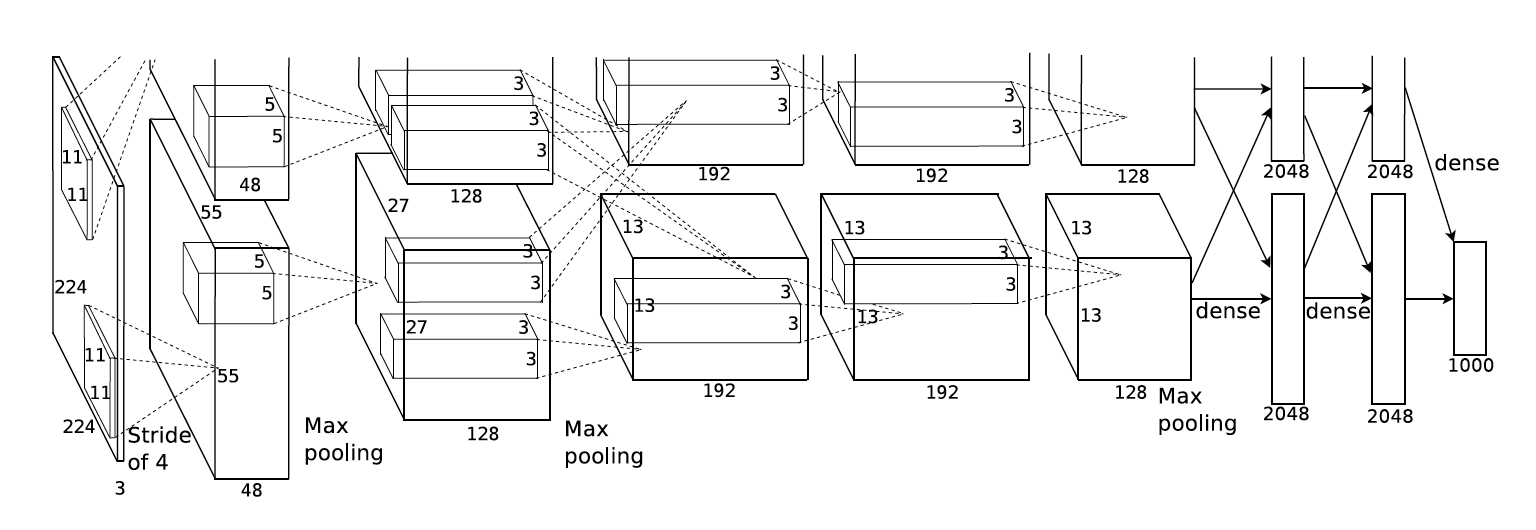
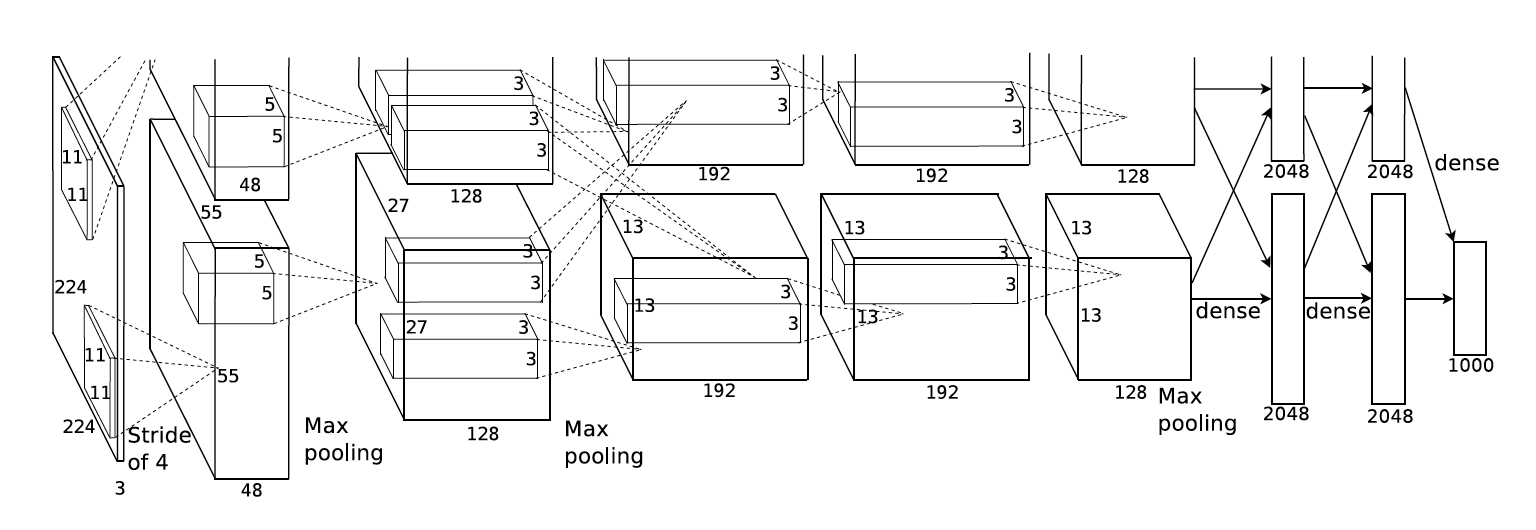
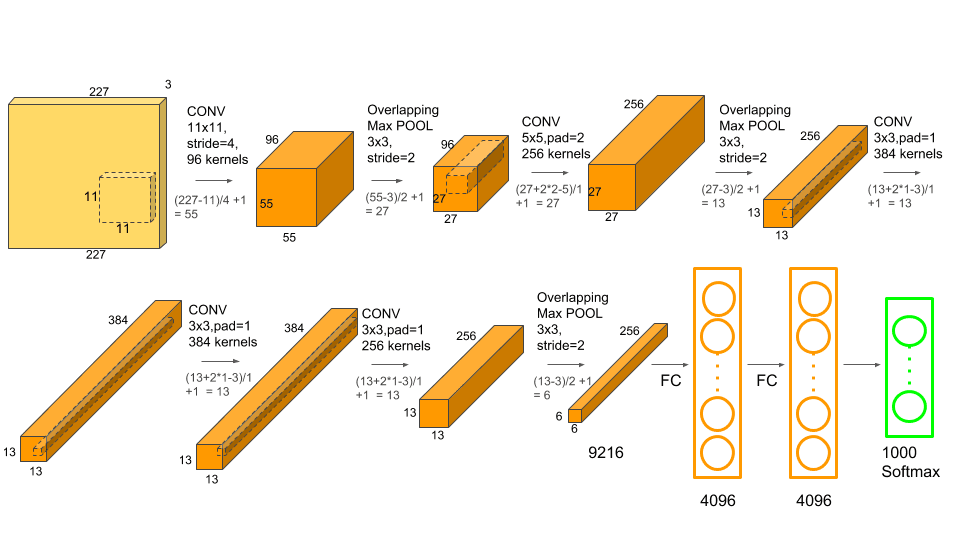
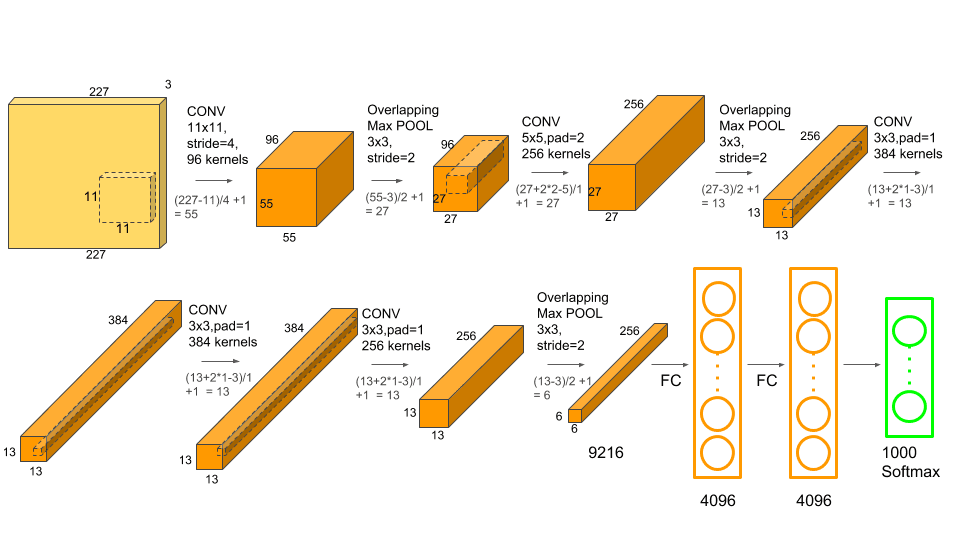

## Overview

 It contains eight learned layers —
 five convolutional and three fully-connected.

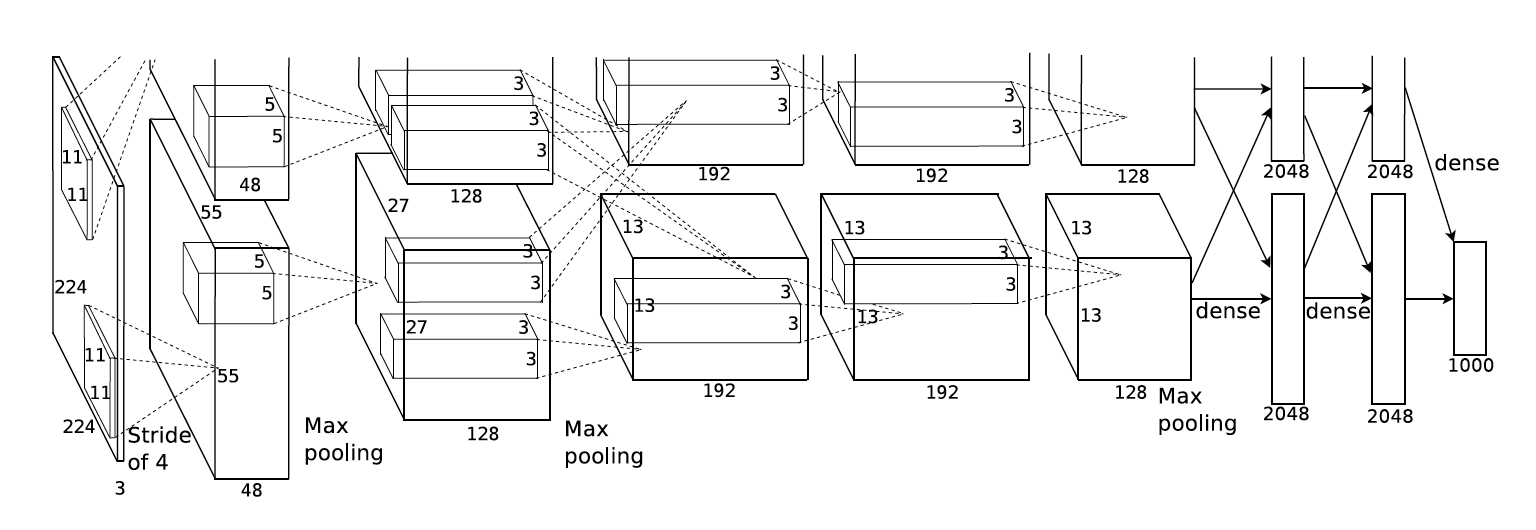

Below, I have describe some of the novel or unusual
 features of alexnet network’s architecture.

### 1. ReLU Nonlinearity

Deep convolutional neural networks with ReLUs train several times faster than their equivalents with tanh units. This is demonstrated in below figure, which shows the number of iterations required to reach 25% training error on the CIFAR-10 dataset for a particular four-layer convolutional network. This plot shows that we would not have been able to experiment with such large neural networks for this work if we had used traditional saturating neuron models.

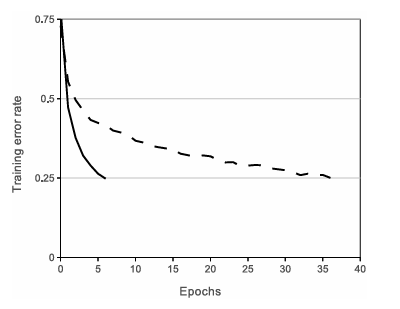

### 2. Local Response Normalization

ReLUs have the desirable property that they do not require input normalization to prevent them from saturating. If at least some training examples produce a positive input to a ReLU, learning will happen in that neuron. However, we still find that the following local normalization scheme aids generalization. Denoting by aixy the activity of a neuron computed by applying kernel i at position(xy) and then applying the ReLU nonlinearity, the response-normalized activity bixy is given by the expression:

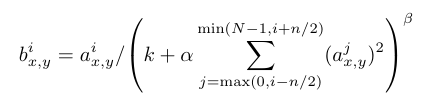

### 3. Overlapping Pooling

Pooling layers in CNNs summarize the outputs of neighboring groups of neurons in the same kernel map. To be more precise, a pooling layer can be thought of as consisting of a grid of pooling units spaced s pixels apart, each summarizing a neighborhood of size z z centered at the location of the pooling unit. 

- If we set s = z, we obtain traditional local pooling as commonly employed in CNNs.
- If we set s < z, we obtain overlapping pooling. 

This is what we use throughout our network, with s = 2 and z = 3. This scheme reduces the top-1 and top-5 error rates by 0.4% and 0.3%, respectively, as compared with the non-overlapping scheme s = 2z = 2, which produces output of equivalent dimensions.

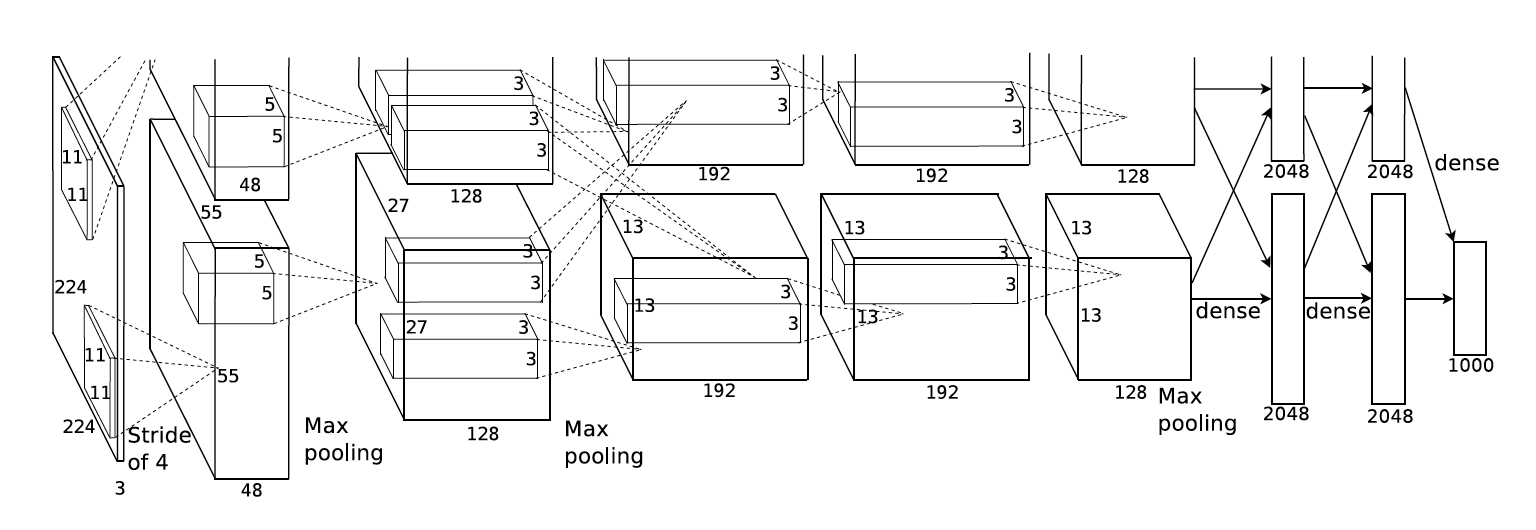
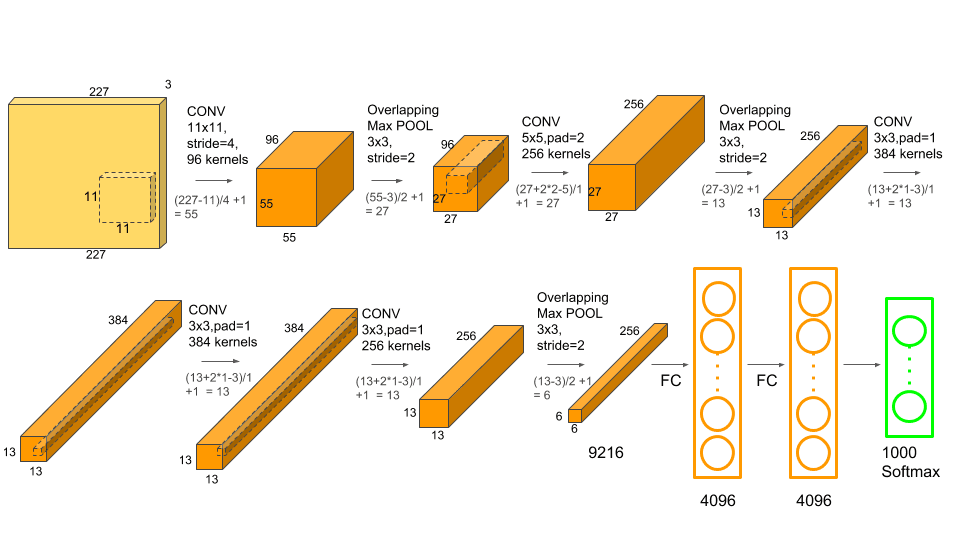
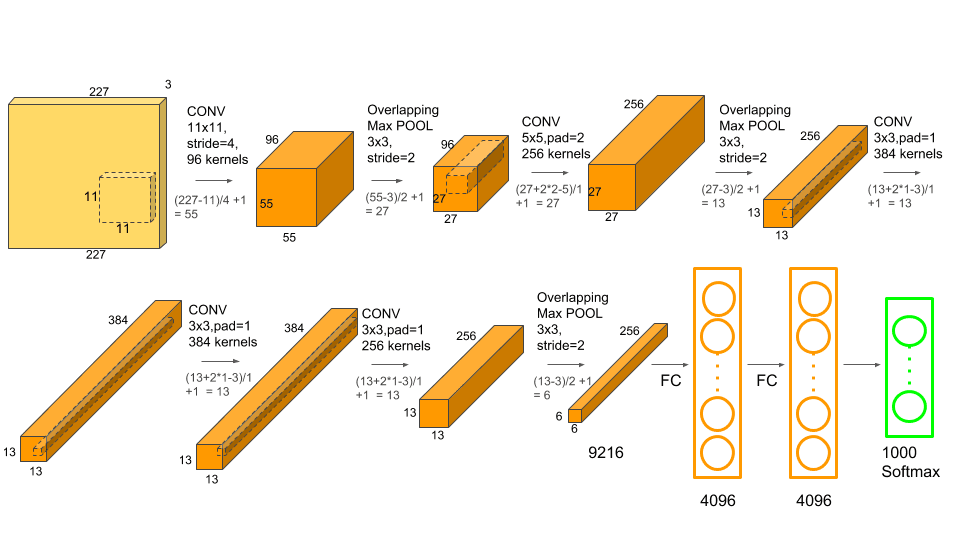

## Overall Architecture

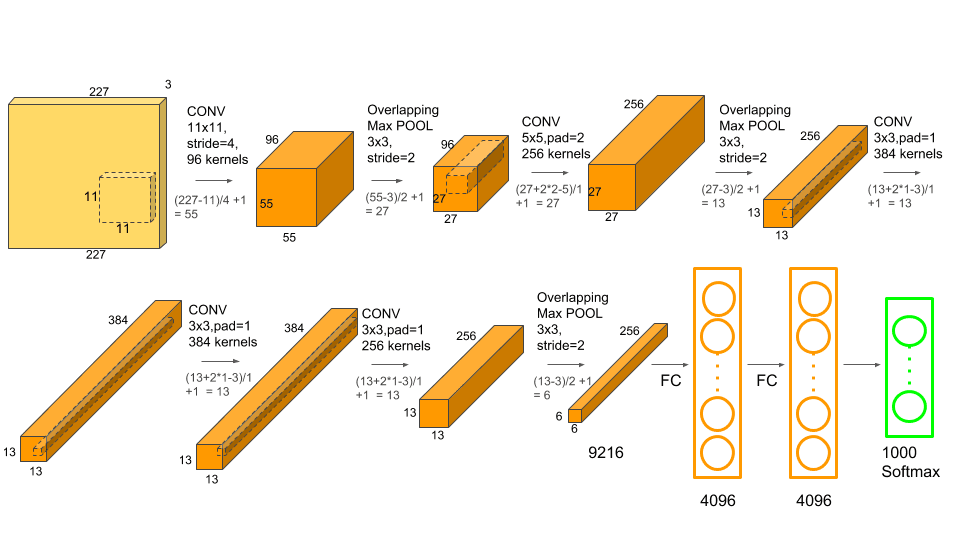

The net contains eight layers with weights; the first five are convolutional and the remaining three are fully connected. 

- The output of the last fully-connected layer is fed to a 1000-way softmax which produces a distribution over the 1000 class labels.

- Our network maximizes the multinomial logistic regression objective, which is equivalent to maximizing the average across training cases of the log-probability of the correct label under the prediction distribution.

- The kernels of the second, fourth, and fifth convolutional layers are connected only to those kernel maps in the previous layer which reside on the same GPU (see Figure 2).

- The kernels of the third convolutional layer are connected to all kernel maps in the second layer.

- The neurons in the fully connected layers are connected to all neurons in the previous layer.

- Response-normalization layers follow the first and second convolutional layers. Max-pooling layers, of the kind described above, follow both response-normalization layers as well as the fifth convolutional layer.

- The ReLU non-linearity is applied to the output of every convolutional and fully-connected layer.

- The first convolutional layer filters the 224 224 3 input image with 96 kernels of size 11 11 3 with a stride of 4 pixels (this is the distance between the receptive field centers of neighboring neurons in a kernel map).

- The second convolutional layer takes as input the (response-normalized and pooled) output of the first convolutional layer and filters it with 256 kernels of size 5 5 48.

- The third, fourth, and fifth convolutional layers are connected to one another without any intervening pooling or normalization layers. The third convolutional layer has 384 kernels of size 3 3 256 connected to the (normalized, pooled) outputs of the second convolutional layer.

- The fourth convolutional layer has 384 kernels of size 3 3 192 , and the fifth convolutional layer has 256 kernels of size 3 3 192. The fully-connected layers have 4096 neurons each.
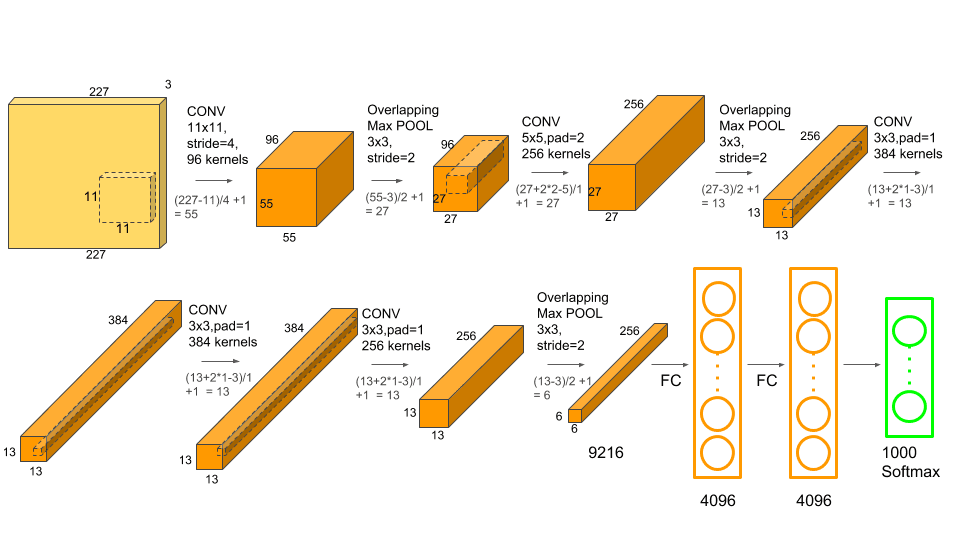

## Implementation

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html


### Alexnet model setup

In [2]:
import torch
import torch.nn as nn

In [3]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        
        # Feature Extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),  # Conv1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # MaxPool1
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),  # Conv2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # MaxPool2
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),  # Conv3
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # Conv4
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # Conv5
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # MaxPool3
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),  # FC1
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),  # FC2
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),  # FC3
        )
    
    def forward(self, x):
        x = self.features(x)  # Pass through convolutional layers
        x = torch.flatten(x, 1)  # Flatten the output for the fully connected layers
        x = self.classifier(x)  # Pass through the classifier
        return x

### Check for GPU

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Importing Dataset

In [5]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

In [6]:
# Transformations (resize for AlexNet input size)
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # AlexNet expects 227x227
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [7]:
# Path to your dataset
data_dir = "/kaggle/input/cifar10-python"

# Load datasets (no download, since files are already there)
train_dataset = CIFAR10(root=data_dir, train=True, transform=transform, download=False)
test_dataset = CIFAR10(root=data_dir, train=False, transform=transform, download=False)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))
print("Classes:", train_dataset.classes)

Train dataset size: 50000
Test dataset size: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
# testing on 1 batch
images, labels = next(iter(train_loader))
print("Image batch shape:", images.shape)  # should be [64, 3, 227, 227]
print("Labels batch shape:", labels.shape) # should be [64]

Image batch shape: torch.Size([64, 3, 227, 227])
Labels batch shape: torch.Size([64])


### Setup training components

In [9]:
# Define device, loss function, and optimizer:
import torch.optim as optim

In [10]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move model to GPU/CPU
model = AlexNet(num_classes=10).to(device)  # CIFAR-10 has 10 classes

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (AlexNet usually uses SGD with momentum)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

# Optional: Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Using device: cuda


### Training loop

In [11]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Stats
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return running_loss / total, 100.0 * correct / total


### Evaluation loop

In [12]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / total, 100.0 * correct / total


### Train for multiple epochs

In [13]:
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)
    
    scheduler.step()  # adjust learning rate if using scheduler

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.2f}%")


Epoch 1/20
  Train Loss: 1.8508, Train Acc: 30.78%
  Val   Loss: 1.4285, Val   Acc: 47.71%
Epoch 2/20
  Train Loss: 1.2453, Train Acc: 55.34%
  Val   Loss: 1.0506, Val   Acc: 62.78%
Epoch 3/20
  Train Loss: 0.9487, Train Acc: 66.90%
  Val   Loss: 0.8951, Val   Acc: 69.86%
Epoch 4/20
  Train Loss: 0.7919, Train Acc: 72.45%
  Val   Loss: 0.7414, Val   Acc: 74.40%
Epoch 5/20
  Train Loss: 0.6681, Train Acc: 76.86%
  Val   Loss: 0.7187, Val   Acc: 74.82%
Epoch 6/20
  Train Loss: 0.5876, Train Acc: 79.74%
  Val   Loss: 0.6295, Val   Acc: 78.80%
Epoch 7/20
  Train Loss: 0.5073, Train Acc: 82.43%
  Val   Loss: 0.5765, Val   Acc: 80.19%
Epoch 8/20
  Train Loss: 0.4586, Train Acc: 84.03%
  Val   Loss: 0.5907, Val   Acc: 80.08%
Epoch 9/20
  Train Loss: 0.3991, Train Acc: 86.27%
  Val   Loss: 0.6069, Val   Acc: 80.42%
Epoch 10/20
  Train Loss: 0.3671, Train Acc: 87.21%
  Val   Loss: 0.5597, Val   Acc: 81.55%
Epoch 11/20
  Train Loss: 0.1742, Train Acc: 94.02%
  Val   Loss: 0.4899, Val   Acc: 84.8

### Lets first save the model

In [14]:
torch.save(model.state_dict(), "alexnet_cifar10.pth")
# And later to load it -
# model.load_state_dict(torch.load("alexnet_cifar10.pth"))
# model.eval()

### Tracking history and Ploting Curves

In [15]:
import matplotlib.pyplot as plt

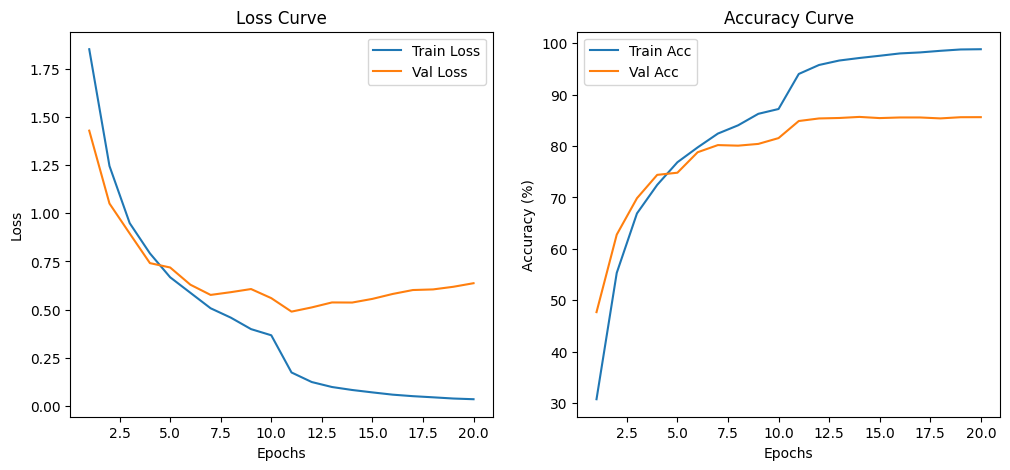

In [16]:
def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Plot Loss
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Curve")
    plt.legend()
    
    plt.show()

plot_history(history)


### Per-class accuracy (confusion matrix on CIFAR-10)

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [18]:
# Put model in evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


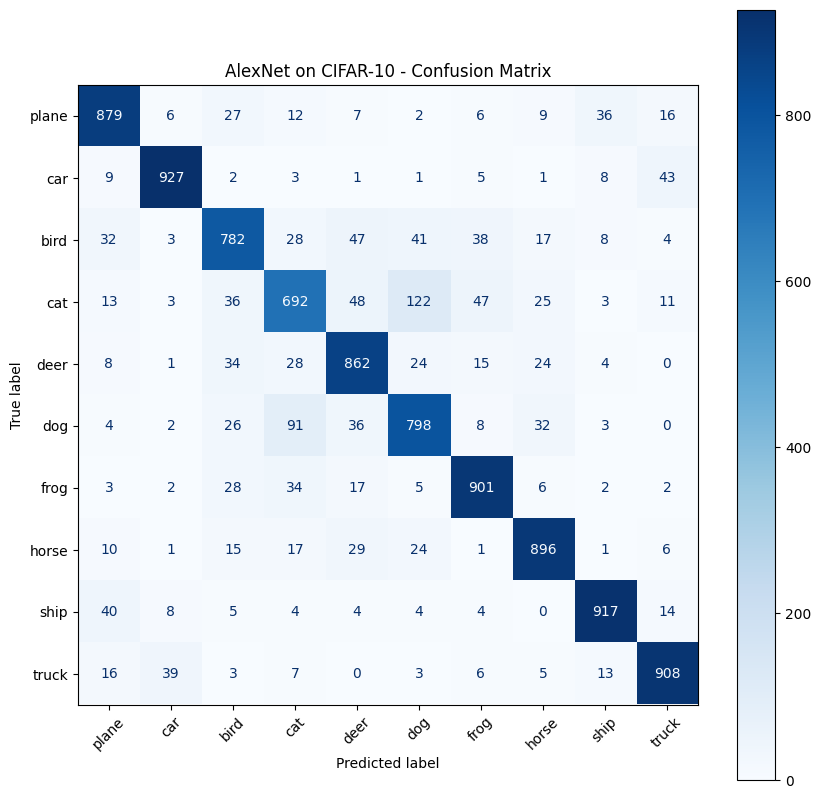

In [19]:
# CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("AlexNet on CIFAR-10 - Confusion Matrix")
plt.show()


In [20]:
cm_diag = cm.diagonal()
per_class_acc = cm_diag / cm.sum(axis=1)

for i, acc in enumerate(per_class_acc):
    print(f"{classes[i]}: {acc*100:.2f}%")

plane: 87.90%
car: 92.70%
bird: 78.20%
cat: 69.20%
deer: 86.20%
dog: 79.80%
frog: 90.10%
horse: 89.60%
ship: 91.70%
truck: 90.80%


## Conclusion

The results show that a large, deep convolutional neural network is capable of achieving record
breaking results on a highly challenging dataset using purely supervised learning. It is notable that the network’s performance degrades if a single convolutional layer is removed. 

For example,removing any of the middle layers results in a loss of about 2% for the top-1 performance of the network. So the depth really is important for achieving our results.